### cleanup bits

load names from names.py

use the Linear, non-linearities etc

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn

context_length = 5

first just load names without spelling it out like before

In [2]:
%run names.py

ns = Names(5)

ns.get_names("names.txt")

x_names, y_names = ns.get_xys()
samples_length = len(y_names)
train_length = math.floor(samples_length * .8)
dev_offset = math.floor(samples_length * .9)

dev = list(zip(x_names[train_length: dev_offset], y_names[train_length: dev_offset]))
test = list(zip(x_names[dev_offset:], y_names[dev_offset:]))

train = list(zip(x_names[:train_length], y_names[:train_length]))

def sample_names(sample_size = 5, p = train):
    samples = random.sample(p, sample_size)
    x_samples = [s[0] for s in samples]
    y_samples = [s[1] for s in samples]
    return x_samples, y_samples
#show it's OK
sample_names()

([[0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [1, 12, 25, 14, 1],
  [0, 0, 13, 1, 18],
  [0, 7, 1, 2, 18]],
 [20, 14, 0, 9, 5])

## a cleaner approach

the cleanup from makemore that follows the torch api for a network

clean Linear layer for an nn

In [3]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out))
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

### Batch norm

In [4]:
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

## non linearities
tanh and relu

In [5]:
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

class Relu:
  def __call__(self, x):
    self.out = torch.relu(x)
    return self.out
  def parameters(self):
    return []

class Gelu:
  def __call__(self, x):
    self.out = torch.gelu(x)
    return self.out
  def parameters(self):
    return []

## Previous example in new network form

In [6]:
n_embd = 9 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

vocab_size = 27
nonlin='relu'

if nonlin=='relu':
    ln = Relu()
else:
    ln = Tanh()

match nonlin:
    case 'relu':
        ln = Relu()
    case 'gelu':
        ln = Gelu()
    case _:
        ln = Tanh()

ln

Seems odd not to add the embedding as a layer in layers?

Also show array with a layer per line - confusing otherwise

Actually Andej does this in the Wavenet lecture...

In [7]:
class Embedding:

    def __init__(self, vocab_size, embedding_dims):
        self.weight = torch.randn(vocab_size, embedding_dims)

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

In [8]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [10]:
@torch.no_grad()
def split_loss(split):
    dx = [s[0] for s in split]
    dy = torch.tensor([s[1] for s in split])
    logits = model(dx)
    return F.cross_entropy(logits, dy).item()

We can choose to use torch implementations just by prepending nn. to Linear and BatchNorm1d

In [11]:
# model = nn.Sequential([
#   nn.Linear(n_embd * context_length, n_hidden, bias=False), 
#   nn.BatchNorm1d(n_hidden), 
#   ln,
#   nn.Linear(    n_hidden       , vocab_size, bias=False), 
#   nn.BatchNorm1d(vocab_size),
# ])

In [20]:
model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * context_length, n_hidden, bias=True), 
    ln,
    Linear(    n_hidden       , vocab_size, bias=True),
])

In [21]:
with torch.no_grad():
    # little odd to doubly init the weights - seems a little ignored in lecture
    nn.init.kaiming_normal_(model.layers[2].weight, nonlinearity=nonlin)
    # this is the tanh adjustment but it seems to work for relu too
    model.layers[2].weight *= 5/3
    # last layer: make less confident
    if hasattr(model.layers[-1], 'gamma'):
        model.layers[-1].gain *= .1
    else:
        model.layers[-1].weight *= 0.5

In [22]:
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
# should probably be a function on the model?
for p in parameters:
  p.requires_grad = True

14870


now reuse our loop with the new architecture

In [23]:
names_length = train_length
epochs = 190
batch_size = 820
sample_loops = 800

In [24]:
learning_rate = .1

running_loss = []
running_lr = []

ud_ratio = []

lr_step = {
    0: { 0: .1, 80: .01, 121: .001},
    9: { 0: .1, 100: .02, 161: .004}
}

lr_step[9]

{0: 0.1, 100: 0.02, 161: 0.004}

In [40]:
lrs = lr_step[n_embd]
if lrs == None:
    lrs = lr_step[0]

for ep in range(epochs):
    epoch_loss = 0
    for s in range(sample_loops):
        x, y = sample_names(batch_size)
        Y = torch.tensor(y)
        
        logits = model(x)
        loss = F.cross_entropy(logits, Y) # loss function

        with torch.no_grad():
            epoch_loss += loss

        # again stuff on parameters should probably be in model?
        for p in parameters:
          p.grad = None
        loss.backward()

        for p in parameters:
            p.data -= learning_rate * p.grad

    #just keep any epoch stuff in a no grad block
    with torch.no_grad():
        if ep in lrs:
            learning_rate = lrs[ep]

        running_loss.append(epoch_loss.item())
        running_lr.append(learning_rate)

        ud_ratio.append([ (learning_rate*p.grad.std()/ p.data.std()).log10().item() for p in parameters ])
    
        if ep % 10 == 0:
            print(epoch_loss/sample_loops)
            learning_rate *= .92
            print(ep, learning_rate)

torch.Size([820, 27]) torch.Size([820])


AttributeError: 'int' object has no attribute 'item'

In [26]:
tr = split_loss(train)
dv = split_loss(dev)
print("train", tr, "dev", dv)

train 1.960763931274414 dev 2.052647829055786


In [19]:
tr = split_loss(train)
dv = split_loss(dev)
print("train", tr, "dev", dv)

train 1.9474741220474243 dev 2.0502021312713623


In [27]:
import matplotlib.pyplot as plt

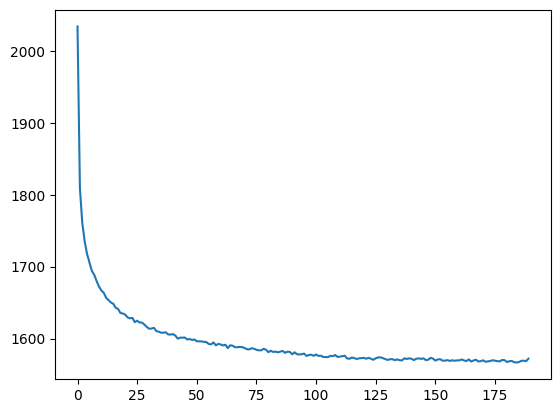

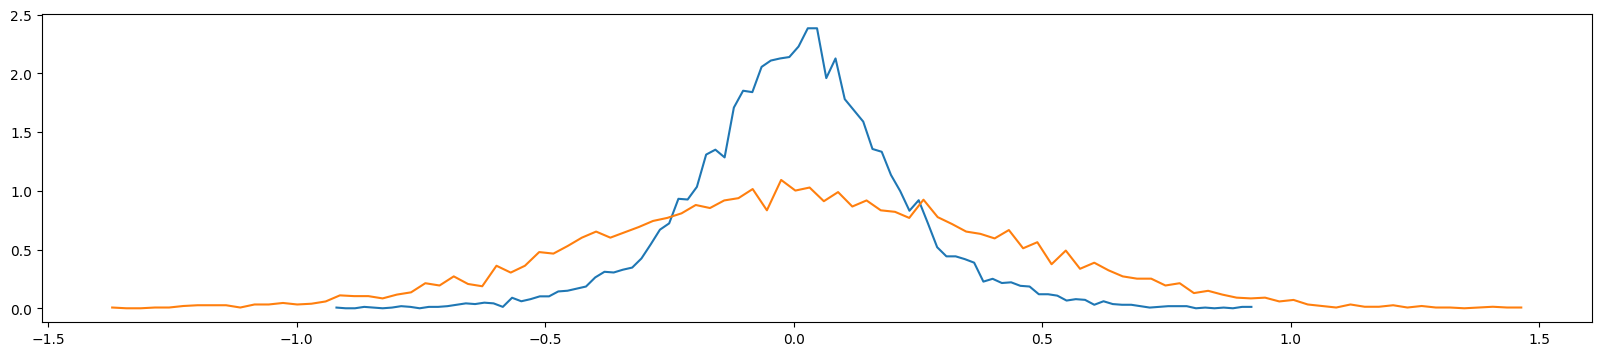

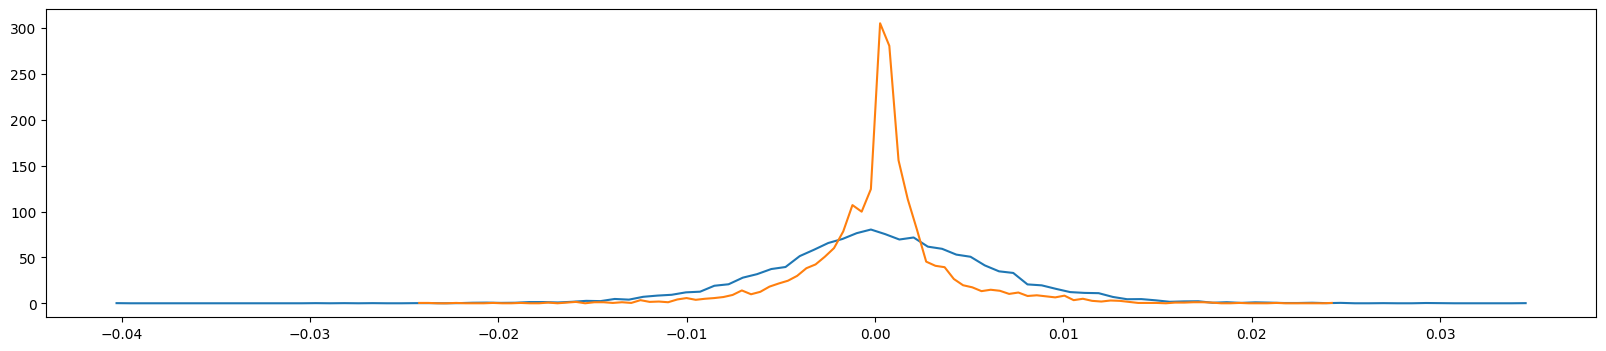

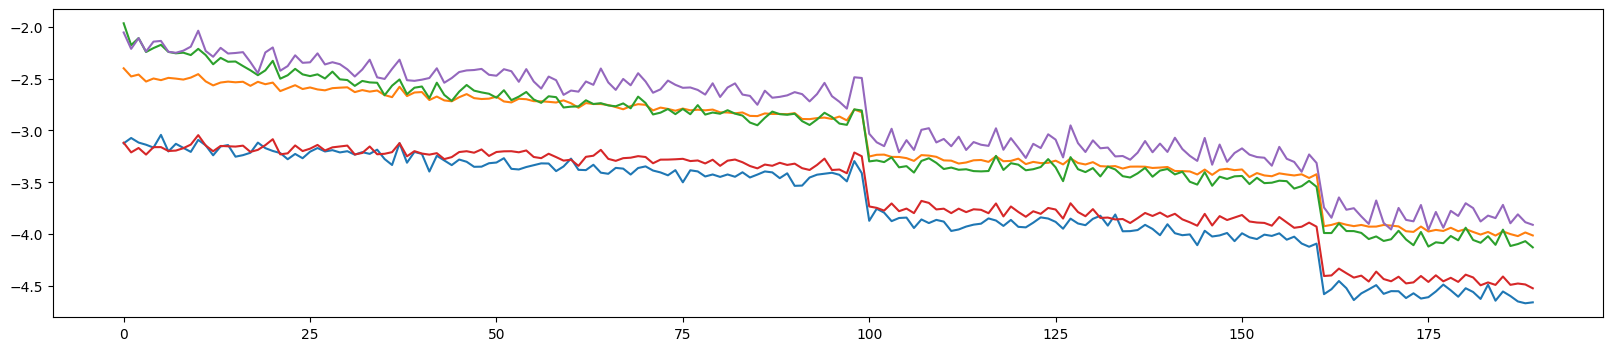

In [39]:
# 9 dims 200 relu, no batch norm
eps = [i for i in range(190)]
ls = [l for l in running_loss]

plt.plot(eps, ls)

t = model.layers[2].weight.detach()
hy, hx = torch.histogram(t, density=True)
plt.figure(figsize=(20,4))
plt.plot(hx.detach()[1:], hy.detach())
t2 = model.layers[-1].weight.detach()
h2y, h2x = torch.histogram(t2, density=True)

plt.plot(h2x.detach()[1:], h2y.detach())

# look at our gradient distributions

t = model.layers[2].weight.grad.detach()
hy, hx = torch.histogram(t, density=True)
plt.figure(figsize=(20,4))
plt.plot(hx.detach()[1:], hy.detach())
t2 = model.layers[-1].weight.grad.detach()
h2y, h2x = torch.histogram(t2, density=True)

plt.plot(h2x.detach()[1:], h2y.detach())

plt.figure(figsize=(20,4))
plt.plot(ud_ratio)

Compare to running this with BatchNorm and the lecture hyperparameters

In [ ]:
model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * context_length, n_hidden  , bias=False), 
    ln, 
    BatchNorm1d(n_hidden),
    Linear(    n_hidden           , vocab_size, bias=False), 
    BatchNorm1d(vocab_size)
])

with torch.no_grad():
    # little odd to doubly init the weights - seems a little ignored in lecture
    nn.init.kaiming_normal_(layers[2].weight, nonlinearity=nonlin)
    # this is the tanh adjustment but it seems to work for relu too
    layers[2].weight *= 5/3
    # last layer: make less confident
    if hasattr(model.layers[-1], 'gamma'):
        model.layers[-1].gain *= .1
    else:
        model.layers[-1].weight *= 0.4

parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [ ]:
epochs = 190
batch_size = 820
sample_loops = 800

learning_rate = .1

running_loss = []
running_lr = []

ud_ratio = []

lr_step = {
    0: { 0: .1},
    9: { 0: .1}
}

lr_step[9]

In [ ]:
lrs = lr_step[n_embd]
if lrs == None:
    lrs = lr_step[0]

for ep in range(epochs):
    epoch_loss = 0
    for s in range(sample_loops):
        x, y = sample_names(batch_size)
        Y = torch.tensor(y)

        for layer in layers:
          # if hasattr(layer, 'weight'):
          #     print(layer.weight.shape)
          x = layer(x)
        loss = F.cross_entropy(x, Y) # loss function

        with torch.no_grad():
            epoch_loss += loss

        # backward pass
        for layer in layers:
          layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
        for p in parameters:
          p.grad = None
        loss.backward()

        for p in parameters:
            p.data -= learning_rate * p.grad

    #just keep any epoch stuff in a no grad block
    with torch.no_grad():
        if ep in lrs:
            learning_rate = lrs[ep]

        running_loss.append(epoch_loss.item())
        running_lr.append(learning_rate)

        ud_ratio.append([ (learning_rate*p.grad.std()/ p.data.std()).log10().item() for p in parameters ])
    
        if ep % 10 == 0:
            print(epoch_loss/sample_loops)
            # learning_rate *= .92
            print(ep, learning_rate)

In [ ]:
tr = split_loss(train)
dv = split_loss(dev)
print("train", tr, "dev", dv)

In [ ]:
eps = [i for i in range(len(running_loss))]
ls = [l for l in running_loss]

plt.plot(eps, ls)

t = layers[2].weight.detach()
hy, hx = torch.histogram(t, density=True)
plt.figure(figsize=(20,4))
plt.plot(hx.detach()[1:], hy.detach())
t2 = layers[-2].weight.detach()
h2y, h2x = torch.histogram(t2, density=True)
plt.plot(h2x.detach()[1:], h2y.detach())

# look at our gradient distributions

t = layers[2].weight.grad.detach()
hy, hx = torch.histogram(t, density=True)
plt.figure(figsize=(20,4))
plt.plot(hx.detach()[1:], hy.detach())
t2 = layers[-2].weight.grad.detach()
h2y, h2x = torch.histogram(t2, density=True)
plt.plot(h2x.detach()[1:], h2y.detach())


plt.figure(figsize=(20,4))
plt.plot(ud_ratio)

In [ ]:
def generate_names(num_names):
    for i in range(num_names):
        out = []
        ix = [0] * context_length
        for nl in range(10):

            logits = model(ix)
            
            p = F.softmax(logits, dim=1)
    
            # ## torch.multinomial pulls out an index in p (num_samples=1) by sampling from the elements in p according to their probabilities 
            # ## (p is normalized in the softmax above)
            prediction = torch.multinomial(p, num_samples=1).item()
            
            ix = [ix[1], ix[2], ix[3], ix[4], prediction]

            if prediction == 0:
                break
            out.append(itos[prediction])
            
        print("".join(out))

generate_names(1)